In [1]:
from src.dataset import SexPredDataset
from src.sexpred import SexPred
from src.train import trainIters

import torch,gensim

DATASET_LOCATION="/home/andres/COMP6321_machine_learning/data/dataset.xml"
PERVS_LOCATION="/home/andres/COMP6321_machine_learning/data/pervs.txt"
EMBEDDINGS_LOCATION="/home/andres/COMP6321_machine_learning/embeddings.bin"

ds=SexPredDataset(DATASET_LOCATION,PERVS_LOCATION,embeddings_file=EMBEDDINGS_LOCATION)
test_size=int(0.2*len(ds))
valid_size=int(0.1*len(ds))
train_size=len(ds)-test_size-valid_size
train_ds,valid_ds,test_ds=torch.utils.data.random_split(ds,(train_size,valid_size,test_size))

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb=gensim.models.KeyedVectors.load_word2vec_format(EMBEDDINGS_LOCATION,binary=True)
emb_tensor=torch.FloatTensor(emb.vectors)

## CONFIG
#########
batch_size=16
epochs=30
learning_rate=1e-3
weight_decay=0
#########
## END CONFIG

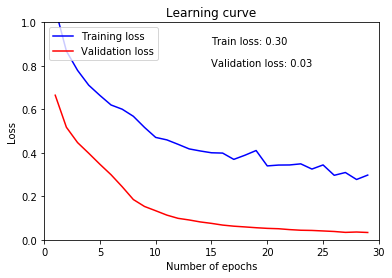

In [2]:
model=SexPred(emb_tensor).to(device)
train_losses,valid_losses=trainIters(model,train_ds,valid_ds,batch_size,epochs,learning_rate,weight_decay)

In [318]:
from src.train import valid
from tqdm import tqdm_notebook as tqdm

def evaluate(model,test_set):
    """returns perplexity of model"""
    loss_avg=[]
    model.eval()
    test_dl = torch.utils.data.DataLoader(test_set,batch_size=16)
    criterion=torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for x,y in tqdm(test_dl,desc="Testing",leave=False):
            input_tensor=x.to(device)
            target=y.to(device)
            loss,_=valid(input_tensor,target,model,criterion)
            loss_avg.append(loss)
        loss_avg=sum(loss_avg)/len(loss_avg)
    return 2**loss_avg

evaluate(RoboPerv,test_ds)

1.1350041592761775

In [301]:
RoboPerv=model
sample=train_ds[4]
x=sample[0].unsqueeze(0)
y=sample[1].unsqueeze(0)
sample=x.to(device),y.to(device)
# RoboPerv(sample).max(-1)[-1]
sample

(tensor([[    1,    11,    40, 12443,   654,   226,    63,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
        device='cuda:0'),
 tensor([[  1,  90,  55,   0,  98, 131,   6,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
        device='cuda:0'))

In [228]:
emb.index2word[90],emb.index2word[55],emb.index2word[98],emb.index2word[131],emb.index2word[6],emb.index2word[0]

('oh', 'ok', 'where', 'did', 'you', 'eos')

In [308]:
def predict(input_,model=model):
    encoder=model.encoder
    decoder=model.decoder
    hidden=encoder.initHidden(1).to(device)
    _,hidden=encoder(input_,hidden)
    pred=torch.tensor([]).unsqueeze(0).to(device)
    pred,h=model.decoder(pred,hidden)
    pred=torch.nn.functional.softmax(pred,dim=-1)
    pred=pred.max(-1)[1]
    print(pred)
                       
#     while token!=0:
#     for n in range(10):
#         pred,hidden=model.decoder(pred,hidden)
#         print(pred.max(-1)[1])
#         pred=pred.max(-1)[1]
#         print(pred)
#         pred=torch.nn.functional.softmax(pred,dim=-1)
#         if len(pred_sent)==1:
#             pred=pred.max(-1)[-1].squeeze().item()
#         else: pred=pred.max(-1)[-1].squeeze()[-1].item()
#         pred_sent.append(pred)
#         print(pred_sent)
            
#         print(pred.shape)
#         print(pred.shape)
#         pred=pred.item()
#         pred_sent.append(pred)
        
#     return pred_sent

predict(sample[0],RoboPerv)
# s=s[:,:1]
# s.shape
# RoboPerv.decoder(s,h)

tensor([[1, 8, 8, 8]], device='cuda:0')


In [238]:
emb.index2word[34],emb.index2word[1556],emb.index2word[1408],emb.index2word[1592]

('html', 'youre', 'clean', 'dinner')